# Imports and Reading Data

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
# Let us start by importing the library from the package directory
import pandas as pd
import numpy as np

import nltk
import re

from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Downloading all the requirements
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Read the data
df_train = pd.read_csv("drive/MyDrive/MLProject/train.csv")
df_test = pd.read_csv("drive/MyDrive/MLProject/test.csv")

# Cosmetics for matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Setting global parameters for the Plots
rcParams['figure.figsize'] = 18, 9 
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5
rcParams['xtick.labelsize'] = 'smaller'
rcParams['ytick.labelsize'] = 'smaller'
rcParams['axes.labelpad'] = 15

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing

In [153]:
# Check the first five rows of our dataset
df_train.head()

,id,text,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
0,a8be7c5d4527adbbf15f,""", 6 December 2007 (UTC)\nI am interested, not...",0,0,0,0,0,0
1,0b7ca73f388222aad64d,I added about three missing parameters to temp...,0,0,0,0,0,0
2,db934381501872ba6f38,SANDBOX?? \n\nI DID YOUR MADRE DID IN THE SANDBOX,1,0,0,0,0,0
3,228015c4a87c4b1f09a7,"why good sir? Why? \n\nYou, sir, obviously do ...",1,0,1,1,1,0
4,b18f26cfa1408b52e949,"""\n\n Source \n\nIncase I forget, or someone e...",0,0,0,0,0,0


In [154]:
#check the first element of the text column
df_train['text'].iloc[0]

'", 6 December 2007 (UTC)\nI am interested, not in arguing, but in the policies which resolve our ongoing content dispute. Also, see Wikipedia: WikiProject United States presidential elections for what I\'ll be working on. Also, the moneybomb closer just self-reverted on two different requests, which echoed what I would have requested.  I will rephrase #3, which I didn\'t see an answer to, building on our agreement that ""moneybomb"" should not be a redlink: Given the deletion reversion, what should be the outline of the article called ""moneybomb"" or should it be submitted for AFD again in due time? (If the latter, see the previous version of #3.) However, this version will require a detailed answer because any ambiguity will only necessitate clarifying questions.   22:32"'

In [155]:
#let us check the count, mean, std and other params of the data
df_train.describe()

,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
count,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000
mean,0.095782,0.010262,0.053067,0.002999,0.049150,0.008975
std,0.294294,0.100781,0.224168,0.054683,0.216182,0.094311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Noise Removal 
(URLs, HTML Tags, Punctuation, Numbers, special characters Extra Whitespace, lowercase)

In [156]:
class noise_removal:

    def __init__(self):
        pass

    def clean(self, df, column):
      
        # applying all the methods in sequence
        df[column]= df[column].apply(self.rm_urls)
        df[column]= df[column].apply(self.rm_html_tags)
        df[column] = df[column].apply(self.rm_non_alpha)
        df[column] = self.rm_whitespace(df, column)

        # lowercasing the text
        df[column] = df[column].str.lower()

        return df

    def rm_urls(self, text):
        return re.sub(r'http\S+', ' ', text)
    
    def rm_html_tags(self, text):
        clean = re.compile('<.*?>')
        return re.sub(clean, ' ', text)

    def rm_non_alpha(self, text):
        return re.sub('[^a-zA-Z]', ' ', text)

    def rm_whitespace(self, df, column):
        return df[column].apply(lambda x : " ".join(x.split()))

In [157]:
df_train = noise_removal().clean(df_train, 'text')
df_test = noise_removal().clean(df_test, 'text')

In [158]:
df_train['text'].iloc[0]

'december utc i am interested not in arguing but in the policies which resolve our ongoing content dispute also see wikipedia wikiproject united states presidential elections for what i ll be working on also the moneybomb closer just self reverted on two different requests which echoed what i would have requested i will rephrase which i didn t see an answer to building on our agreement that moneybomb should not be a redlink given the deletion reversion what should be the outline of the article called moneybomb or should it be submitted for afd again in due time if the latter see the previous version of however this version will require a detailed answer because any ambiguity will only necessitate clarifying questions'

### Spell Checker

In Natural Language Processing it’s important that spelling errors should be as less as possible so that whatever we are making should be highly accurate.

In [159]:
# from textblob import TextBlob

# df['text'] = df['text'].apply(lambda x : TextBlob(x).correct())

### Lemmatization

Comparing between Lemmatization and stemming -

Stemming just removes or stems the last few characters of a word, often leading to incorrect meanings and spelling. Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma. Sometimes, the same word can have multiple different Lemmas.

* If you lemmatize the word 'Caring', it would return 'Care'. If you stem, it would return 'Car' and this is erroneous.

* If you lemmatize the word 'Stripes' in verb context, it would return 'Strip'. If you lemmatize it in noun context, it would return 'Stripe'. If you just stem it, it would just return 'Strip'.
* You would get same results whether you lemmatize or stem words such as walking, running, swimming... to walk, run, swim etc.


In [160]:
def lemm(df, column):
    lemma = WordNetLemmatizer()

    # Lemmatizing with respect to the verb form and noun form
    df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='n') for w in x.split(" ")]))
    df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='v') for w in x.split(" ")]))

    return df

In [161]:
df_train = lemm(df_train, 'text')
df_test = lemm(df_test, 'text')

In [162]:
df_train.text.iloc[0]

'december utc i be interest not in argue but in the policy which resolve our ongoing content dispute also see wikipedia wikiproject unite state presidential election for what i ll be work on also the moneybomb closer just self revert on two different request which echo what i would have request i will rephrase which i didn t see an answer to build on our agreement that moneybomb should not be a redlink give the deletion reversion what should be the outline of the article call moneybomb or should it be submit for afd again in due time if the latter see the previous version of however this version will require a detail answer because any ambiguity will only necessitate clarify question'

### Remove Stop Words

In [163]:
# Generating all the stop words of english and removing no,not nor as they are significantly important
stop = stopwords.words('english')
not_stop_words = {'no', 'not', 'nor'}
modified_stop = [ele for ele in stop if ele not in not_stop_words]

def remove_stop_words(df, column):
    
    df[column] = df[column].apply(lambda x : ' '.join([word for word in x.split(' ') if word not in modified_stop]))
    return df

In [164]:
df_train = remove_stop_words(df_train, 'text')
df_test = remove_stop_words(df_test, 'text')

###Remove words of length <=2

In [165]:
# As the words with less than length 2 will not contribute to toxicity in a general manner
def clean_small(text):
    return re.sub(r'\b\w{1,2}\b', '', text)

# After every re.sub we get varied amount of whitespaces so it is essential to remove white spaces
def remove_less_2(df, column):
    df[column] = df[column].apply(clean_small)
    df[column] = noise_removal().rm_whitespace(df, column)
    return df

In [166]:
df_train = remove_less_2(df_train, 'text')
df_test = remove_less_2(df_test, 'text')

# Todo
**Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon'.We will remove all such words which has three consecutive repeating characters.**

**stopwords without (no not aur nor)**

# EDA (Exploratory Data Analysis)

### Count of comments per category

To get a better sense of our MultiLabel Classification we would start by plotting the number of texts in each category.

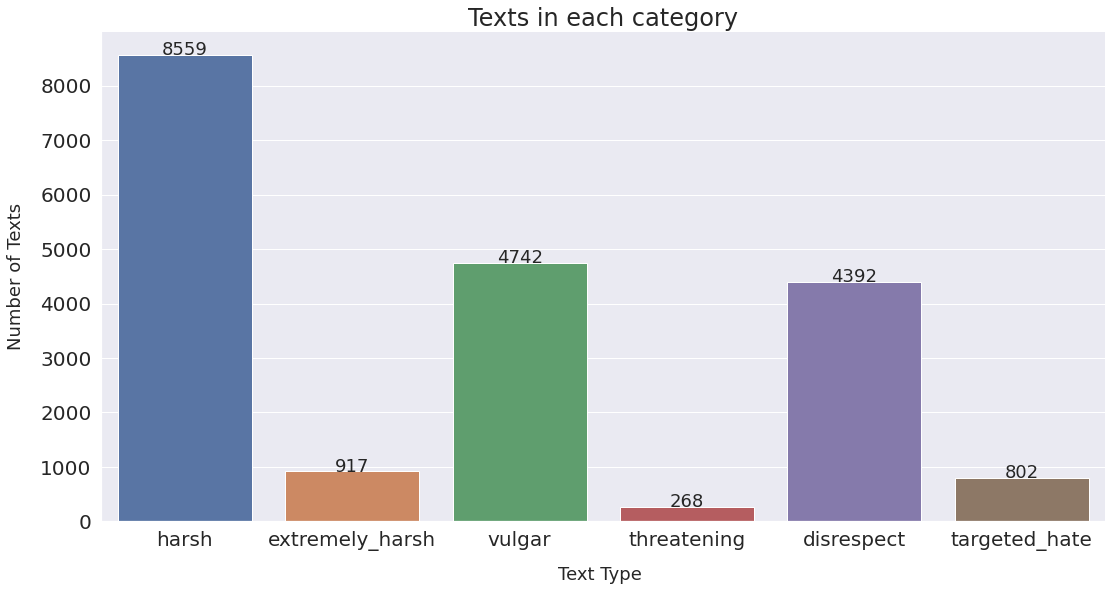

In [167]:
# List all the target columns
categories = list(df_train.columns.values)
categories.remove('id')
categories.remove('text')

#Plot
ax = sns.barplot(x=categories, y=df_train.iloc[:, 2:].sum().values)

#Labelling
plt.title("Texts in each category", fontsize=24)
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Text Type ', fontsize=18)

#For accessing the subplots in the graph
rects = ax.patches

category_values = df_train.iloc[:, 2:].sum().values

#For each subplot we need to assign a x coordinate, y coordinate and label with the orientation and fontsize
for rect, label in zip(rects, category_values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha='center', fontsize=18)

plt.show()

**Observations**: Harsh is the most common type of text and is nearly equal to the sum of all other types of texts whereas threatening, extremely_harsh, targeted_hate are the rare ones among all of them. Some more interdependent labels will be discussed in later part of the module.

### Count of comments with multiple labels

Now let us count the number of comments having multiple labels.

In [168]:
# Finding the rows which correspond to the toxic comments by looking at the toxic column's values.
df_toxic = df_train[(df_train[['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']] > 0).any(axis=1)]
len(df_toxic)

9076

There are only 9076 "Toxic comments" out of 89,359 total comments.

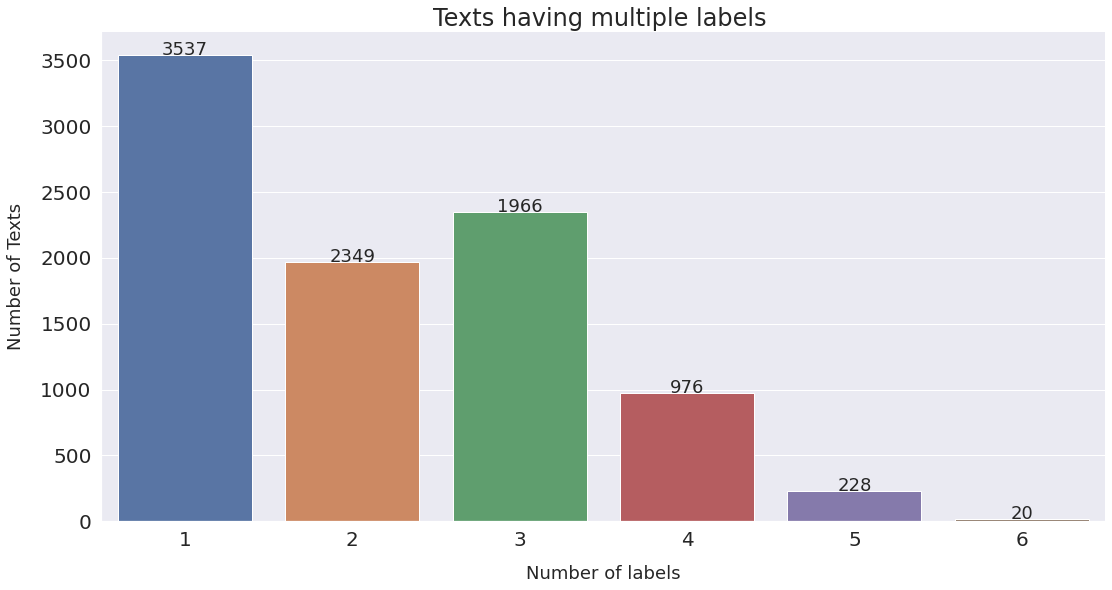

In [169]:
#Sums of the toxic columns for each row
rowSums = df_train.iloc[:, 2:].sum(axis=1)

# corresponding value counts for number of toxic labels
multiLabel_counts = rowSums.value_counts()

#Taking all the non-zero aka toxic comments counts only
multiLabel_counts = multiLabel_counts.iloc[1:]

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Texts having multiple labels ")
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

# adding the text labels
rects = ax.patches
category_values = multiLabel_counts.values

for rect, label in zip(rects, category_values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha='center', fontsize=18)
            
plt.show()

**Observations**: All 6 labels at the same time is extremely rare and only one label takes up the majority.

### Top words

Now, let us find the top 100 words by frequency (for toxic comments only)

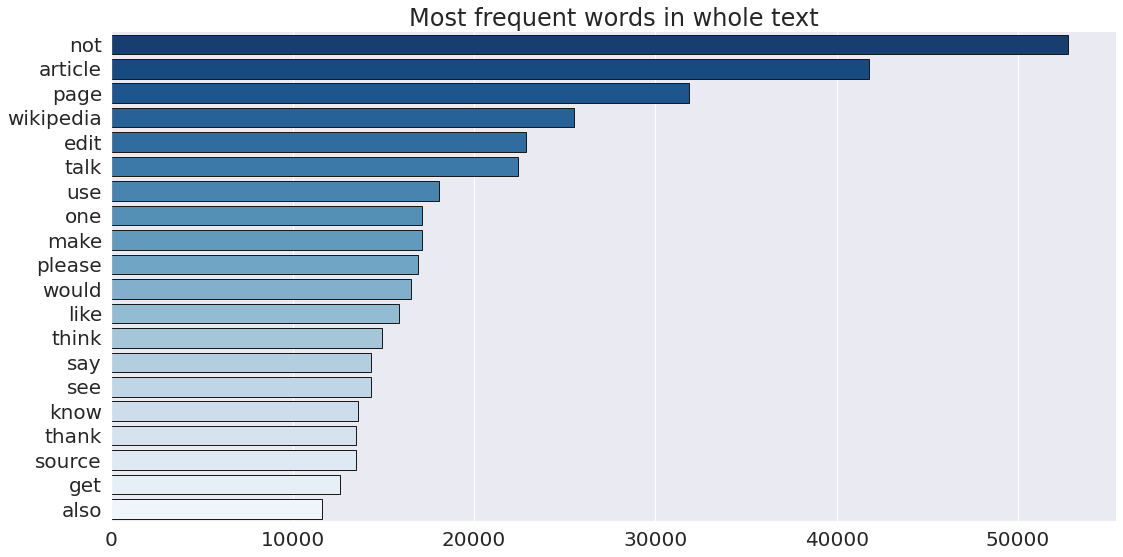

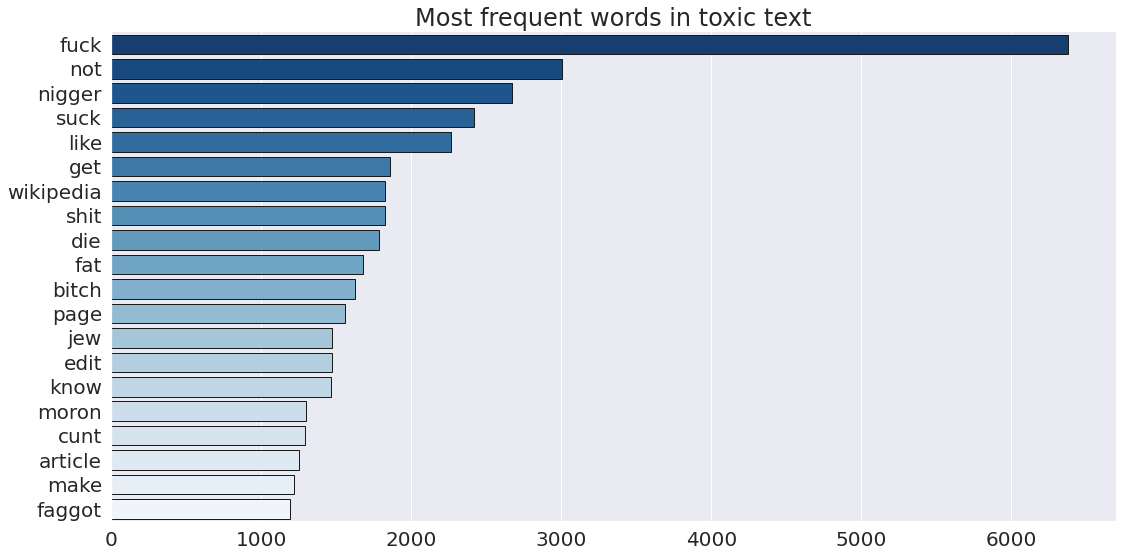

In [170]:
# value counts of each word in all the sentences.
words = pd.Series(' '.join(df_train.text).lower().split()).value_counts()
toxic_words = pd.Series(' '.join(df_toxic.text).lower().split()).value_counts()

sns.barplot(y=words.iloc[:20].index, x=words.iloc[:20].values, palette='Blues_r', edgecolor="k", linewidth=1)
plt.title("Most frequent words in whole text")
plt.show()

ax = sns.barplot(y=toxic_words.iloc[:20].index, x=toxic_words.iloc[:20].values, palette='Blues_r', edgecolor="k", linewidth=1)
plt.title("Most frequent words in toxic text")
plt.show()

**Observation**: "Clean" words are more frequent than "Toxic" words. This was expected because only about 10% comments are toxic.

### Wordcloud

Let us make a WordCloud to better understand the occurrences of the words which constitute in the majority.

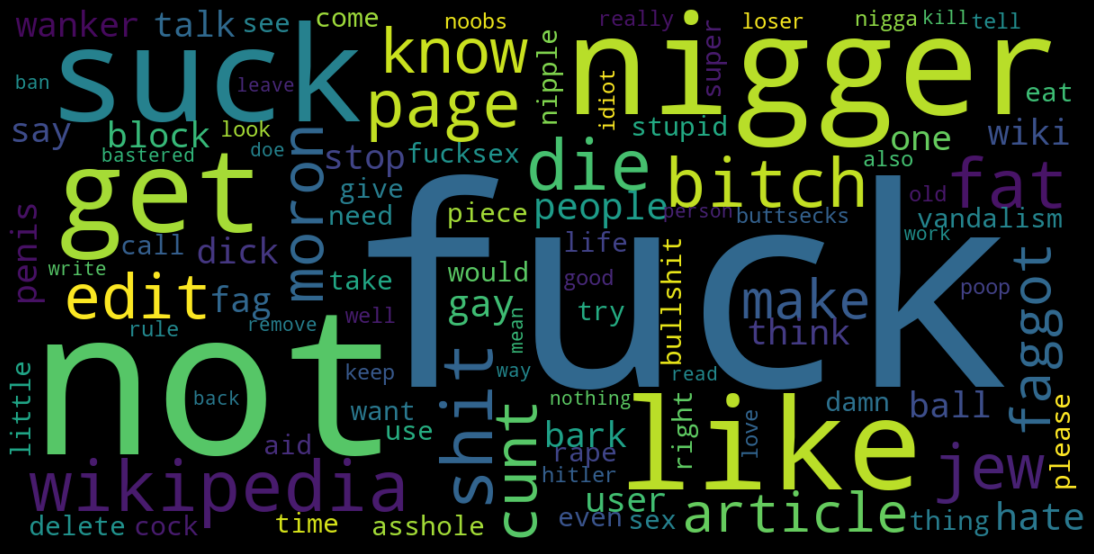

In [171]:
def generate_word_cloud(text):
    wordcloud = WordCloud(background_color = 'black', scale=3, max_words=100).generate_from_frequencies(text)

    fig = plt.figure(figsize = (15, 15), facecolor = 'black', edgecolor = 'black')
    
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

generate_word_cloud(toxic_words)

### Length of Comments

Next, we will plot the length of comments. We can observe that most comments are less than 500 characters long.

Text(0, 0.5, 'Count of Comments')

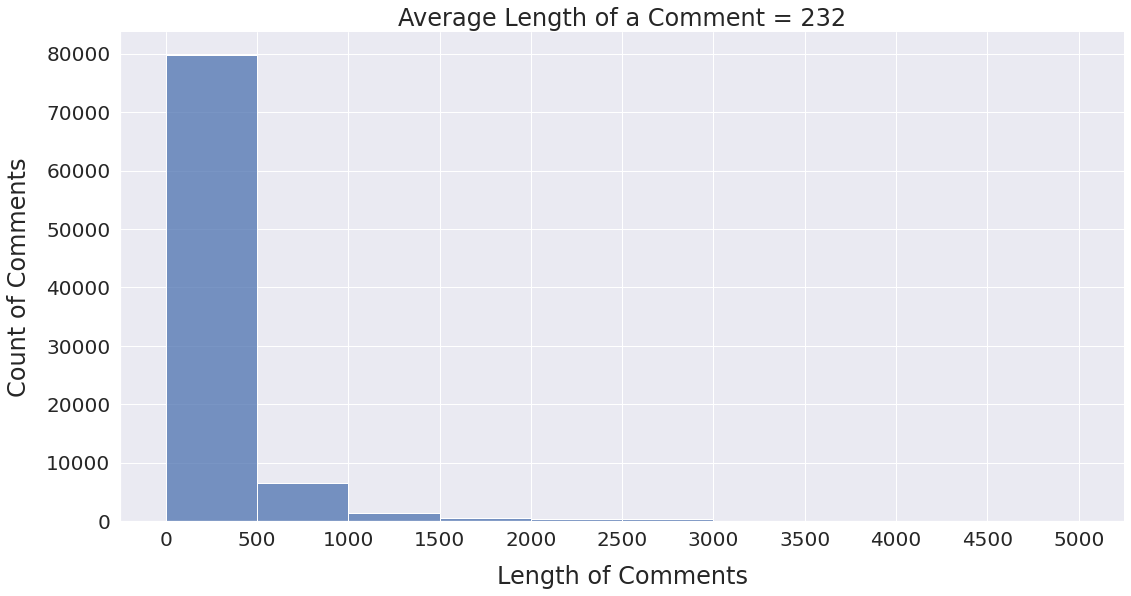

In [172]:
text_len = df_train.text.str.len()

plt.title("Average Length of a Comment = " + str(int(text_len.mean())))
plt.xticks(range(0, 5000+1, 500))

ax = sns.histplot(text_len, binwidth=500)
ax.set_xlabel('Length of Comments')
ax.set_ylabel('Count of Comments')

# Text -> Features

### BOW (Bag of Words)

Each text is represented as a vector consisting of the frequency / occurence(0,1) / weighted values of vocabulary (list of unique words).

Disadvantages ->
1.	Vocabulary can become too large
2.	Each text vector will contain many 0's which will result in a sparse matrix (Why is that a problem?)
3.	Ordering of the words (grammar, meaning) is lost
4.	Words which occur frequently across all text vectors may introduce a bias.

### TF-IDF (Term Frequency and Inverse document Frequency)

TF-IDF kind of normalizes the text vectors. Frequent words in a text-vector are "rewarded", but they also get "punished" if they are frequent in other text-vectors too. Thus, higher weight is assigned to unique or rare terms considering all text-vectors.

<!-- TF(t,d) = (count of t in document d) / (Total words in document d)

IDF(t) = log(Total documents / Number of documents containing t)

![TF-IDF](assets/IDF.png "TF_IDF") -->

Disadvantages ->

1. TF-IDF is basically BOW with weights. It cannot capture the semantics / meaning of text.

In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Explore other parameters of TfidVectorizer
vectorizer = TfidfVectorizer(binary=True)

# Learn vocabulary and idf from training docs. Returns document-term matrix
TF_IDF_train = vectorizer.fit_transform(df_train['text'])

# Tranaform test docs to document-term matrix
TF_IDF_test = vectorizer.transform(df_test['text'])

In [174]:
vectorizer.get_feature_names()

# Spell Check necessary?

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaa',
 'aaaa',
 'aaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany',
 'aaaaaaaaaah',
 'aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaah',
 'aaaannnnyyyywwwwhhhheeeerrrreeee',
 'aaaawwww',
 'aaaboyz',
 'aaages',
 'aaaghh',
 'aaah',
 'aaahhh',
 'aaai',
 'aaajade',
 'aaand',
 'aaaww',
 'aaba',
 'aaberg',
 'aabove',
 'aac',
 'aachen',
 'aachi',
 'aacs',
 'aad',
 'aademia',
 'aadmi',
 'aaffect',
 'aafia',
 'aaflight',
 'aage',
 'aagin',
 'aah',
 'aai',
 'aaiha',
 'aajonus',
 'aakash',
 'aake',
 'aalborg',
 'aalertbot',
 'aalexa',
 'aaliya',
 'aaliyah',
 'aalst',
 'aam',
 'aamir',
 'aamirjamil',
 'aamu',
 'aanas',
 'aand',
 'aang',
 'aao',
 'aaot',
 'aap',
 'aapl',
 'aapropriate',
 'aar',
 'aarabs',
 'aarau',
 'aardvark',
 'aare',
 'aarem',
 'aaroamal',
 'aarohi',
 'aaron',
 'aaroncrick',
 'aaronic',
 'aaronshavit',
 'aaronsw',
 'aarp',
 'aarrow',
 'aarticles',
 'aaruveetil',
 'aat',
 'aatc',
 'aau',
 'aave',
 'aaviksoo',
 'aavishkaar',
 'aaw',
 'aayege',
 'aba

In [175]:
# vectorizer.vocabulary_

# Train-Test Split

In [176]:
Y_train = df_train.drop(columns=["id", "text"]).to_numpy()

In [177]:
X_train = TF_IDF_train
X_test = TF_IDF_test

# Model Selection and Training

This is a <b>multi-label classification</b> problem (Text can be classified into multiple labels simultaneosly or none)

NOTE - This is different from <b>multi-class classification</b> in which the sample is assigned to only a single class from the pool of multiple classes.

## OneVsRest

### Logistic Regression

Training

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

LR = []

#Making LR list for all the 6 target columns and applying logistic regression on all of them considering they are independent  
for i in range(Y_train.shape[1]):
  LR.append(LogisticRegression().fit(X_train, Y_train[:, i]))

Inference - Train data

In [179]:
Y_train_pred = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred[:, i] = LR[i].predict(X_train)

In [180]:
Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred_prob[:, i] = LR[i].predict_proba(X_train)[:, 1]

In [181]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred)

0.6851497194514543

In [182]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred_prob)

0.9909609104364369

Inference - Test data

In [183]:
Y_test_pred = np.ones((X_test.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_test_pred[:, i] = LR[i].predict(X_test)

In [184]:
Y_test_pred_prob = np.ones((X_test.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_test_pred_prob[:, i] = LR[i].predict_proba(X_test)[:, 1]

### Random Forest

Training

In [196]:
from sklearn.ensemble import RandomForestClassifier

RF =[]

#Making RF list for all the 6 target columns and applying Random forest classifier on all of them considering they are independent  
for i in range(Y_train.shape[1]):
  print(i)
  RF.append(RandomForestClassifier(max_depth=10,n_estimators=200,min_samples_leaf=50).fit(X_train, Y_train[:, i]))

0
1
2
3
4
5


Inference - Train data

In [197]:
Y_train_pred = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred[:, i] = RF[i].predict(X_train)

In [198]:
Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred_prob[:, i] = RF[i].predict_proba(X_train)[:, 1]

In [199]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred)

0.5

In [200]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred_prob)

0.9689500456144717

# Exporting test predictions

In [185]:
#Assigning the columns to the obtained data
df_export = pd.DataFrame(data=Y_test_pred_prob, columns=["harsh", "extremely_harsh","vulgar","threatening","disrespect","targeted_hate"])

In [186]:
#appending id in the start
df_export.insert(loc=0, column='id', value=df_test['id'])

In [187]:
#exporting it in the end
df_export.to_csv('prediction.csv',index=False)